## Comparación de los distintos algoritmos de detección - DB y EAST.
- De ahi se elige DB porque es mejor, y se pasa a la versión entrenada con más datos que es la que usamos.

## Comparación de los distintos algoritmos de reconocimiento - CRNN y SVTR.
- Para comparar CRNN y SVTR, podemos usar los entrenados por el PP-OCR-v3 y listo


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys

sys.path.append("../")

from src.detection.prediction_utils import choose_model, filter_predictions
from src.ocr_utils.ocr import get_ocr_model, reescale, predict_ocr
from src.line_detection.hough import get_tablas


2023-02-27 01:14:08.764603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 01:14:11.544151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-27 01:14:11.544566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packag

In [4]:
from PIL import Image
from IPython.display import display
from torchvision import transforms as T
import numpy as np
import cv2
from glob import glob
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

In [5]:
from paddleocr.paddleocr import PaddleOCR
from paddleocr.tools.infer import predict_det, predict_rec
from paddleocr.tools.infer import utility
from paddleocr.tools.infer.predict_system import sorted_boxes
from paddleocr.tools.infer.utility import get_rotate_crop_image, get_minarea_rect_crop

In [31]:
FILES = glob("../data/images_testing/ocr*.jpeg") + glob("../data/images_testing/ocr*.png")

map_files = {
    '../data/images_testing/ocr_test1.jpeg': \
            "/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-65.png",
    
    '../data/images_testing/ocr_test2.png':\
            "/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-5.png",
    
    '../data/images_testing/ocr_test3.jpeg':\
            "/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-63.png",
    
    '../data/images_testing/ocr_test4.png':\
            "/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-11.png",
    
    '../data/images_testing/ocr_test5.jpeg':\
            "/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-15.png", 
      }

## Utils

In [7]:
def draw_bbox(img, xmin, ymin, xmax, ymax, color):
    isClosed = True
    thickness = 2
    pts = np.array([xmin, ymin, xmax, ymax])
    return cv2.polylines(img, [pts], isClosed, color, thickness)

def visualize_boxes(img, boxes, color=(0, 255, 0)):
    img = np.array(img)
    for b in boxes:
        xmin = b[0].astype(int).tolist()
        ymin = b[1].astype(int).tolist()
        xmax = b[2].astype(int).tolist()
        ymax = b[3].astype(int).tolist()
        img = draw_bbox(img, xmin, ymin, xmax, ymax, color)
    return Image.fromarray(img)


def images_together(images, titles=[]):
    # figure size in inches optional
    rcParams['figure.figsize'] = (14, 14)

    # display images
    fig, ax = plt.subplots(1,len(images))
    
    for i in range(len(images)):
        ax[i].imshow(images[i])
        ax[i].set_title(titles[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.show()

## Detección - DB vs EAST

In [ ]:
args = utility.init_args()
args = args.parse_args(args=[])
args.det_model_dir = "../ocr/db/inference/"
db = predict_det.TextDetector(args)

args = utility.init_args()
args = args.parse_args(args=[])
args.det_model_dir = "../ocr/east/inference/"
args.det_algorithm = "EAST"
args.det_east_cover_thresh = 0.20
east = predict_det.TextDetector(args)

In [ ]:
default = PaddleOCR(lang="en")

In [ ]:
where_to_search = ["/home/nacho/TFI-Cazcarra/data/csv/train_diagramas_2023.csv", 
                  "/home/nacho/TFI-Cazcarra/data/csv/test_diagramas_2023.csv"]
scale_percent = 100
for img_path in FILES:
    img = Image.open(img_path).convert("RGB")
    img_arr = img if isinstance(img, np.ndarray) else np.array(img)
    tablas, cardinalidades = get_tablas(map_files[img_path], where_to_search)
    results_img = []
    for t in tablas:
        tabla_cropped = img_arr[t[1]:t[3], t[0]:t[2]]
        if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
            tabla_cropped = tabla_cropped[:,:,:3]
        boxes_db, scores = db(tabla_cropped)
        print(len(boxes_db))
        boxes_east, _ = east(tabla_cropped)
        print(len(boxes_east))
        boxes_default, _ = default.text_detector(tabla_cropped)
        plotted_db = visualize_boxes(tabla_cropped, boxes_db, color=(0, 0, 255))
        plotted_east = visualize_boxes(tabla_cropped, boxes_east, color=(0, 255, 0))
        plotted_default = visualize_boxes(tabla_cropped, boxes_default, color=(255, 0, 0))
                
        display(images_together([tabla_cropped, plotted_db, plotted_east, plotted_default],
                               titles=["Imagen original", "Predicciones DB", "Predicciones EAST", 
                                       "Predicciones DB v2*"]))

## Reconocimiento - CRNN vs SVTR

In [8]:
crnn = PaddleOCR(ocr_version="PP-OCRv2")
svtr = PaddleOCR(ocr_version="PP-OCRv3", lang="en")
# crnn = PaddleOCR(rec_algorithm="CRNN", det_algorithm="DB", lang="en")

[2023/02/27 01:14:26] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/nacho/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/nacho/.paddleocr/whl/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgn

../data/images_testing/ocr_test4.png


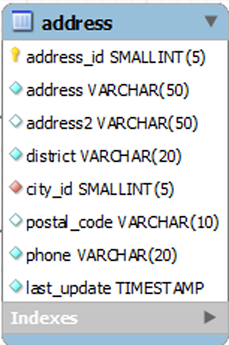

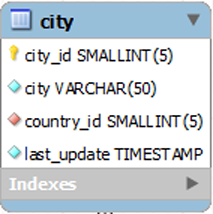

../data/images_testing/ocr_test2.png


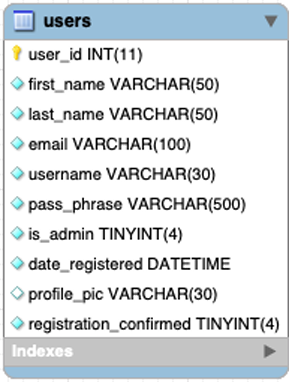

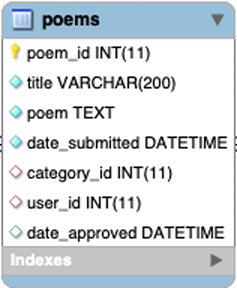

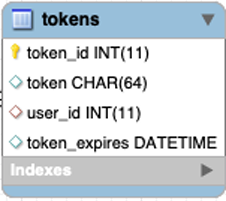

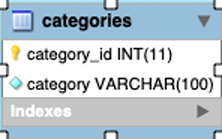

In [16]:
where_to_search = ["/home/nacho/TFI-Cazcarra/data/csv/train_diagramas_2023.csv", 
                  "/home/nacho/TFI-Cazcarra/data/csv/test_diagramas_2023.csv"]
scale_percent = 150
img_dict_svtr = {}
img_dict_crnn = {}
FILES = [f for f in FILES if "png" in f]
for img_path in FILES:
    print(img_path)
    img = Image.open(img_path).convert("RGB")
    img_arr = img if isinstance(img, np.ndarray) else np.array(img)
    tablas, cardinalidades = get_tablas(map_files[img_path], where_to_search)
    results_img = []
    tablas_dict_svtr = {}
    tablas_dict_crnn = {}
    for t in tablas:
        tabla_cropped = img_arr[t[1]:t[3], t[0]:t[2]]
        tabla_cropped = reescale(tabla_cropped, scale_percent)
        if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
            tabla_cropped = tabla_cropped[:,:,:3]
        display(Image.fromarray(tabla_cropped))
        ori_im = np.array(tabla_cropped).copy()
        dt_boxes = svtr.text_detector(tabla_cropped)[0]
        dt_boxes = sorted_boxes(dt_boxes)
        img_crop_list = []
        for bno in range(len(dt_boxes)):
            tmp_box = copy.deepcopy(dt_boxes[bno])
            img_crop = get_rotate_crop_image(ori_im, tmp_box)
            img_crop_list.append(img_crop)
            display(Image.fromarray(img_crop))
        
        results_svtr = svtr.text_recognizer(img_crop_list)
        results_crnn = crnn.text_recognizer(img_crop_list)
        
        tablas_dict_svtr[str(t)] = [r[0] for r in results_svtr[0]]
        tablas_dict_crnn[str(t)] = [r[0] for r in results_crnn[0]]
        
    img_dict_crnn[img_path] = tablas_dict_crnn
    img_dict_svtr[img_path] = tablas_dict_svtr    

In [26]:
for k in img_dict_crnn['../data/images_testing/ocr_test4.png']:
    print(img_dict_crnn['../data/images_testing/ocr_test4.png'][k], ",")

['maddress', '1 ADDRESS ID SMALLINT (5)', ' address VARCHAR(50)', ' address2 VARCHAR(50)', '< distict VARCAR(20)', 'GTy _IDd SMALLINT (5)', '? postal_COde VARCHAR(10)', ': PHONE VARCHAR(20)', '>last update TIMESTAMP', 'Indexes', 'V'] ,
['』aty', '7 GTY_ID SMALLINT (5)', ': dty VARCHAR(50)', ': COUNTRY ID SMALLINT (5)', 'OlAST UPDATE TIMESTAMP', 'Indexes', 'V'] ,


In [30]:
ocr = PaddleOCR(lang="en")

In [35]:
all_imgs = {}

where_to_search = ["/home/nacho/TFI-Cazcarra/data/csv/train_diagramas_2023.csv", 
                  "/home/nacho/TFI-Cazcarra/data/csv/test_diagramas_2023.csv"]


for img_path in FILES:
    img = Image.open(img_path).convert("RGB")
    display(img_path, img)
    img_arr = img if isinstance(img, np.ndarray) else np.array(img)
    tablas, cardinalidades = get_tablas(map_files[img_path], where_to_search)
    results_img = []
    tablas_dict_svtr = {}
    tablas_dict_crnn = {}

    preds = predict_ocr(img_arr, tablas, ocr, scale_percent=150)[0]

    all_texts = []
    for k in preds.keys():
        text = [k]
        for k,v in preds[k].items():
            text.append(k)
            text.append(v)
        text.append("Indexes")
        all_texts.append(text)
    all_imgs[img_path] = all_texts 

In [36]:
all_ocrs = []

for k in sorted(all_imgs):
    all_ocrs.append(all_imgs[k])

In [38]:
all_ocrs